## Calculating Displacement in a Fixed Beam Subjected to a Transverse Force

### **1. Beam Setup and Assumptions**

- **Cantilever Beam**: A beam anchored firmly at one end (the fixed end) and extending freely at the other (the free end).
  
- **Transverse Force (\( F \))**: A force applied perpendicular to the beam's axis, causing bending.

- **Material Properties**:
  - **Young's Modulus (\( E \))**: Measures the stiffness of the material.
  - **Moment of Inertia (\( I \))**: Depends on the beam's cross-sectional geometry, influencing its resistance to bending.

- **Assumptions**:
  - **Linear Elasticity**: The material deforms elastically, and Hooke's Law applies.
  - **Small Deformations**: Deflections are small relative to the beam's length, allowing linear approximations.
  - **Euler-Bernoulli Beam Theory**: Assumes that plane sections remain plane and perpendicular to the neutral axis after deformation.

### **2. Governing Equations**

Under the Euler-Bernoulli beam theory, the relationship between the applied transverse force and the resulting displacement is governed by the following differential equation:

$$
EI \frac{d^2 w(z)}{dz^2} = M(z)
$$

Where:
- \( w(z) \) is the transverse displacement at a position \( z \) along the beam.
- \( M(z) \) is the bending moment at position \( z \).

For a **cantilever beam** with a transverse force \( F \) applied at the free end (\( z = L \)), the bending moment varies linearly from the fixed end to the free end:

$$
M(z) = -F (L - z)
$$

### **3. Boundary Conditions**

To solve the differential equation, we apply the following boundary conditions:

1. **At the Fixed End (\( z = 0 \))**:
   - **No Displacement**: \( w(0) = 0 \)
   - **No Rotation**: 
     $$
     \frac{dw}{dz}\bigg|_{z=0} = 0
     $$

2. **At the Free End (\( z = L \))**:
   - **Maximum Deflection**: 
     $$
     \frac{d^2w}{dz^2}\bigg|_{z=L} = \frac{F}{EI}
     $$
   - **Maximum Slope**: 
     $$
     \frac{d^3w}{dz^3}\bigg|_{z=L} = 0
     $$

### **4. Analytical Solution for Displacement**

Solving the differential equation with the above boundary conditions yields the displacement \( w(z) \) along the beam:

$$
w(z) = \frac{F}{6EI} z^2 (3L - z)
$$

This equation provides the **exact solution** for the transverse displacement of a cantilever beam under a concentrated force at the free end.

### **5. Interpretation of the Solution**

- **Maximum Deflection**: Occurs at the free end (\( z = L \)):

  $$
  w_{\text{max}} = \frac{F L^3}{3EI}
  $$

- **Displacement Distribution**: The displacement \( w(z) \) increases with \( z^2 \) near the fixed end and decreases as \( z \) approaches \( L \).

- **Impact of Material and Geometry**:
  - **Stiffer Materials (\( E \))**: Result in smaller deflections.
  - **Larger Moment of Inertia (\( I \))**: Indicates a more resistant beam to bending, also leading to smaller deflections.
  - **Longer Beams (\( L \))**: Exhibit greater deflections under the same load.

### **6. Numerical Implementation**

In computational simulations  the displacement can be calculated by:

1. **Defining the Geometry**: Specify the beam's length, cross-sectional area, and moment of inertia.

2. **Applying Boundary Conditions**:
   - **Dirichlet Conditions**: Fix displacements at \( z = 0 \) (no movement).
   - **Neumann Conditions**: Apply the transverse force \( F \) at \( z = L \).

3. **Solving the Governing Equations**: Using numerical methods to approximate the displacement \( w(z) \) across the beam.

4. **Visualization**: Plotting the original and deformed shapes of the beam to analyze the displacement pattern.







In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import torch
import plotly.graph_objs as go
import plotly.io as pio
import plotly.graph_objs as go


# Configure Plotly to display in Jupyter
pio.renderers.default = "notebook_connected"

#  Define the beam geometry as a 3D cuboid
# The beam extends from (0, 0, 0) to (1, 1, 6)
geom = dde.geometry.Cuboid([0, 0, 0], [1, 1, 6])



Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# This the exact solution for validation (displacements u, v, w)
def exact_solution(x, F=1.0, E=1.0, A=1.0):
    """
    Exact solutions for displacements u, v, w.
    - u(z) = (F / (E * A)) * z
    - v(z) = 0
    - w(z) = 0
    """
    x = np.atleast_2d(x)
    u = (F / (E * A)) * x[:, 2:3]  # Displacement in x
    v = np.zeros_like(u)           # Displacement in y
    w = np.zeros_like(u)           # Displacement in z
    return np.hstack([u, v, w])

# Applied force in the x direction
force_value = 1.0  

#  Neumann force for u
def neumann_force_u(x):
    """
    Neumann boundary condition for the derivative of u with respect to z at z=6.
    u_z = F / (E * A)
    """
    E = 1.0  # Young's modulus
    A = 1.0  # Cross-sectional area
    F = force_value  # Magnitude of the applied force in x
    u_z = F / (E * A)
    return np.full(x.shape[0], u_z)  # Returns a 1D array

# Neumann force for v
def neumann_force_v(x):
    """
    Neumann boundary condition for the derivative of v with respect to z at z=6.
    v_z = 0
    """
    return np.zeros(x.shape[0])  # Returns a 1D array of zeros

# Neumann force for w
def neumann_force_w(x):
    """
    Neumann boundary condition for the derivative of w with respect to z at z=6.
    w_z = 0
    """
    return np.zeros(x.shape[0])  # Returns a 1D array of zeros



In [3]:
#  Define the boundary conditions

def boundary_fixed(x, on_boundary):
    """
    Dirichlet boundary condition to fix the beam at z=0.
    u = v = w = 0 at z=0.
    """
    return on_boundary and np.isclose(x[2], 0)

def boundary_force(x, on_boundary):
    """
    Neumann boundary condition to apply forces at z=6.
    u_z = F / (E * A), v_z = w_z = 0 at z=6.
    """
    return on_boundary and np.isclose(x[2], 6)

# Dirichlet conditions for u, v, w at z=0
bc_u = dde.DirichletBC(geom, lambda x: 0, boundary_fixed, component=0)
# Dirichlet conditions for v and w at z=0
bc_v = dde.DirichletBC(geom, lambda x: 0, boundary_fixed, component=0)
bc_w = dde.DirichletBC(geom, lambda x: 0, boundary_fixed, component=0)

# Neumann conditions for u_z, v_z, w_z at z=6
bc_neumann_u = dde.NeumannBC(geom, neumann_force_u, boundary_force, component=0)
# Neumann conditions for v_z and w_z at z=6
bc_neumann_v = dde.NeumannBC(geom, neumann_force_v, boundary_force, component=0)
bc_neumann_w = dde.NeumannBC(geom, neumann_force_w, boundary_force, component=0)




In [4]:
# Define the PDEs for u, v, w

def pde_u(x, u):
    """
    Differential equation for displacement u in the x direction.
    Equilibrium equation: d²u/dz² = 0
    """
    u_zz = dde.grad.hessian(u, x, component=0, i=2, j=2)
    return u_zz

def pde_v(x, v):
    """
    Differential equation for displacement v in the y direction.
    Equilibrium equation: d²v/dz² = 0
    """
    v_zz = dde.grad.hessian(v, x, component=0, i=2, j=2)
    return v_zz

def pde_w(x, w):
    """
    Differential equation for displacement w in the z direction.
    Equilibrium equation: d²w/dz² = 0
    """
    w_zz = dde.grad.hessian(w, x, component=0, i=2, j=2)
    return w_zz


In [7]:
# Define the problem data for u, v, w

# Problem data for u
data_u = dde.data.PDE(
    geom,
    pde_u,
    [bc_u, bc_neumann_u],
    num_domain=10000,    # Number of points in the domain
    num_boundary=2000,   # Number of points on the boundary
)

# Problem data for v
data_v = dde.data.PDE(
    geom,
    pde_v,
    [bc_v, bc_neumann_v],
    num_domain=10000,
    num_boundary=2000,
)

# Problem data for w
data_w = dde.data.PDE(
    geom,
    pde_w,
    [bc_w, bc_neumann_w],
    num_domain=10000,
    num_boundary=2000,
)

# Define the neural network architecture
layers = [3] + [50] * 4 + [1]  # 3 inputs (x, y, z), 4 hidden layers with 50 neurons each, 1 output (u, v, w)
activation = "tanh"
initializer = "Glorot normal"

# Create neural networks for u, v, w
net_u = dde.maps.FNN(layers, activation, initializer)
net_v = dde.maps.FNN(layers, activation, initializer)
net_w = dde.maps.FNN(layers, activation, initializer)


In [8]:
# Create and compile the models with the corrected Neumann conditions
model_u = dde.Model(data_u, net_u)
model_v = dde.Model(data_v, net_v)
model_w = dde.Model(data_w, net_w)

# Compile the models with the "adam" optimizer
model_u.compile("adam", lr=1e-3)
model_v.compile("adam", lr=1e-3)
model_w.compile("adam", lr=1e-3)

# Train the models with the "adam" optimizer
losshistory_u, train_state_u = model_u.train(iterations=2000)
losshistory_v, train_state_v = model_v.train(iterations=2000)
losshistory_w, train_state_w = model_w.train(iterations=2000)

# Refine the models with the "L-BFGS" optimizer
model_u.compile("L-BFGS")
losshistory_u, train_state_u = model_u.train()

model_v.compile("L-BFGS")
losshistory_v, train_state_v = model_v.train()

model_w.compile("L-BFGS")
losshistory_w, train_state_w = model_w.train()


Compiling model...
'compile' took 0.596382 s

Compiling model...
'compile' took 0.000099 s

Compiling model...
'compile' took 0.000069 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.99e-03, 7.22e-02, 8.99e-01]    [3.99e-03, 7.22e-02, 8.99e-01]    []  
1000      [5.78e-05, 8.73e-06, 1.19e-05]    [5.78e-05, 8.73e-06, 1.19e-05]    []  
2000      [1.99e-05, 5.21e-06, 6.26e-06]    [1.99e-05, 5.21e-06, 6.26e-06]    []  

Best model at step 2000:
  train loss: 3.14e-05
  test loss: 3.14e-05
  test metric: []

'train' took 147.791242 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.22e-03, 7.32e-03, 1.40e-03]    [1.22e-03, 7.32e-03, 1.40e-03]    []  
1000      [5.15e-07, 5.05e-08, 6.76e-08]    [5.15e-07, 5.05e-08, 6.76e-08]    []  
2000      [1.24e-07, 1.30e-08, 1.87e-08]    [1.24e-07, 1.30e-08, 1.87e-08]    []  

Best model at step 2000:
  t

<Figure size 1000x600 with 0 Axes>

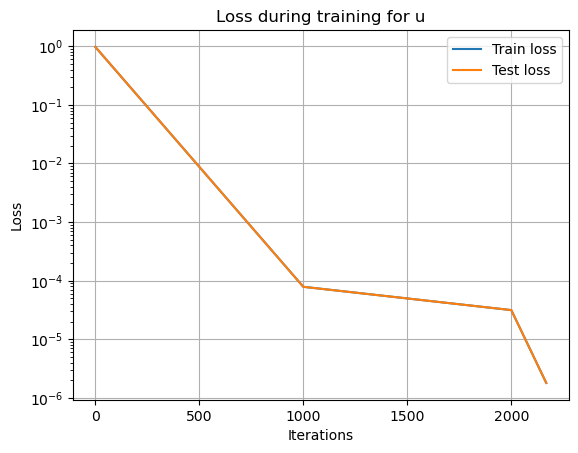

<Figure size 1000x600 with 0 Axes>

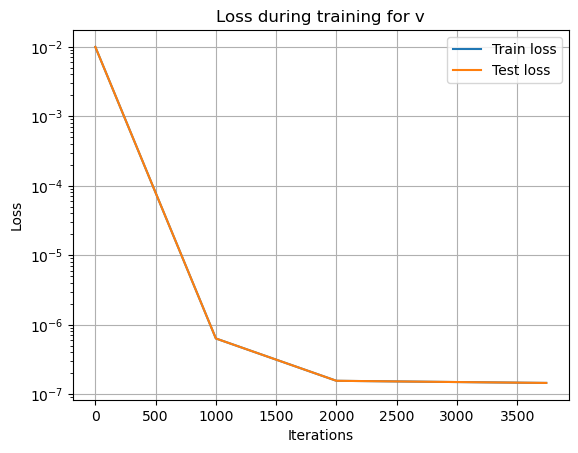

<Figure size 1000x600 with 0 Axes>

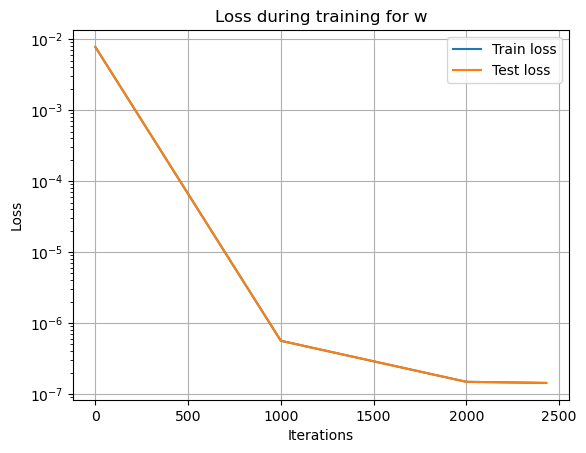

In [14]:
# Save and plot the loss during training

# Visualization of the loss for u
plt.figure(figsize=(10, 6))
dde.utils.plot_loss_history(losshistory_u)
plt.title('Loss during training for u')  
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')  # Logarithmic scale for better visualization
plt.grid(True)
plt.show()

# Visualization of the loss for v
plt.figure(figsize=(10, 6))
dde.utils.plot_loss_history(losshistory_v)
plt.title('Loss during training for v')  
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

# Visualization of the loss for w
plt.figure(figsize=(10, 6))
dde.utils.plot_loss_history(losshistory_w)
plt.title('Loss during training for w')  
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.show()



In [25]:
# Validation against the exact solution

# Generate a mesh of points for comparison
# Since the solution only depends on z, we can simplify point generation
z_test = np.linspace(0, 6, 100).reshape(-1, 1)  # 100 points in z from 0 to 6
x_test = np.zeros_like(z_test)  # x = 0 (since u does not depend on x and y)
y_test = np.zeros_like(z_test)  # y = 0

# Combine coordinates to form X_test
X_test = np.hstack([x_test, y_test, z_test])  # Shape: (100, 3)

# Get predictions from the models
u_pred = model_u.predict(X_test)
v_pred = model_v.predict(X_test)
w_pred = model_w.predict(X_test)

# Compute the exact solution
u_exact, v_exact, w_exact = exact_solution(X_test).T  # Transpose to separate columns

# Calculate the error
error_u = np.abs(u_exact - u_pred.flatten())
error_v = np.abs(v_exact - v_pred.flatten())
error_w = np.abs(w_exact - w_pred.flatten())

print(f'Max error in u: {np.max(error_u):.6f}')
print(f'Average error in u: {np.mean(error_u):.6f}')
print(f'Max error in v: {np.max(error_v):.6f}')
print(f'Average error in v: {np.mean(error_v):.6f}')
print(f'Max error in w: {np.max(error_w):.6f}')
print(f'Average error in w: {np.mean(error_w):.6f}')




Max error in u: 0.039579
Average error in u: 0.025529
Max error in v: 0.001547
Average error in v: 0.000974
Max error in w: 0.004208
Average error in w: 0.001831


In [16]:
# Visualize the 3D deformation of the beam

# Generate a 3D mesh for visualization
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)
z_vals = np.linspace(0, 6, 60)
xx, yy, zz = np.meshgrid(x_vals, y_vals, z_vals)
X_vis = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T  # Shape: (24000, 3)

# Get predictions from the models for deformation
u_pred_vis = model_u.predict(X_vis)
v_pred_vis = model_v.predict(X_vis)
w_pred_vis = model_w.predict(X_vis)

# Combine predictions to obtain the displacement vector
displacement = np.hstack([u_pred_vis, v_pred_vis, w_pred_vis])  # Shape: (24000, 3)

# Calculate deformed positions
X_def = X_vis + displacement  # Original position + displacement

# Select a sample of points for visualization (e.g., 1000 random points)
sample_indices = np.random.choice(len(X_vis), size=1000, replace=False)
X_original = X_vis[sample_indices]
X_deformed = X_def[sample_indices]

# Create traces for the original and deformed beam
trace_original = go.Scatter3d(
    x=X_original[:, 0],
    y=X_original[:, 1],
    z=X_original[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color='blue',
        opacity=0.5,
        symbol='circle'
    ),
    name='Original'
)

trace_deformed = go.Scatter3d(
    x=X_deformed[:, 0],
    y=X_deformed[:, 1],
    z=X_deformed[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color='red',
        opacity=0.5,
        symbol='diamond'
    ),
    name='Deformed'
)

# Configure the layout
layout = go.Layout(
    title='3D Deformation of the Beam',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    legend=dict(x=0.7, y=0.95)
)


fig = go.Figure(data=[trace_original, trace_deformed], layout=layout)
fig.show()


In [24]:
# Visualize the 3D deformation of the beam with surfaces

import plotly.graph_objs as go
import numpy as np

# Define the vertices of the original beam
vertices_original = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 0, 6],
    [1, 0, 6],
    [1, 1, 6],
    [0, 1, 6],
])

# Define the faces of the cuboid (using triangles)
faces = [
    [0, 1, 2], [0, 2, 3],  # Bottom
    [4, 5, 6], [4, 6, 7],  # Top
    [0, 1, 5], [0, 5, 4],  # Front
    [1, 2, 6], [1, 6, 5],  # Right
    [2, 3, 7], [2, 7, 6],  # Back
    [3, 0, 4], [3, 4, 7],  # Left
]

# Create lists of indices for Plotly Mesh3d
i = [face[0] for face in faces]
j = [face[1] for face in faces]
k = [face[2] for face in faces]

# Apply the deformation to the vertices using the exact solution
displacements = exact_solution(vertices_original)  # Use the exact_solution function defined earlier
vertices_deformed = vertices_original + displacements

# Create the Mesh3d for the original beam
mesh_original = go.Mesh3d(
    x=vertices_original[:, 0],
    y=vertices_original[:, 1],
    z=vertices_original[:, 2],
    i=i,
    j=j,
    k=k,
    color='blue',
    opacity=0.5,
    name='Original'
)

# Create the Mesh3d for the deformed beam
mesh_deformed = go.Mesh3d(
    x=vertices_deformed[:, 0],
    y=vertices_deformed[:, 1],
    z=vertices_deformed[:, 2],
    i=i,
    j=j,
    k=k,
    color='red',
    opacity=0.5,
    name='Deformed'
)

# Configure the layout
layout = go.Layout(
    title='3D Deformation of the Beam: Original vs Deformed',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    legend=dict(x=0.7, y=0.95)
)

# Create the figure and add the Mesh3d
fig = go.Figure(data=[mesh_original, mesh_deformed], layout=layout)
fig.show()
